In [157]:
! pip install mne numpy scipy matplotlib tensorflow skfeature-chappers seaborn

Defaulting to user installation because normal site-packages is not writeable


In [158]:
import mne
import warnings
import numpy as np
from importlib import reload
from Functions import Data_path, Filtering, Common_average_reference
from Functions import Plot_features, CCA_Feature_Extraction
from Functions import Feature_selections

from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import model_selection, metrics, neural_network, tree, naive_bayes, discriminant_analysis, neighbors
from sklearn import preprocessing, svm, ensemble, linear_model

from tensorflow.keras.utils import to_categorical  # Convert labels to categorical (one-hot encoding)
import tensorflow as tf
from tensorflow import keras
from Functions import ROC
import joblib


import sys

np.set_printoptions(threshold=sys.maxsize)


In [159]:
# Define the base folder path where the data is located
folder_path = "/home/ubie/Desktop/Telekinesis/classify/Data" 
path_files, files, folders = Data_path.data_path(folder_path, data_format="gdf") 
path_files

['/home/ubie/Desktop/Telekinesis/classify/Data/Subject2-[2012.04.07-19.27.02].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject2-[2012.04.07-19.36.29].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject2-[2012.04.07-19.44.23].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject2-[2012.04.07-19.57.52].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject3-[2012.04.07-18.17.50].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject3-[2012.04.07-18.27.18].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject3-[2012.04.07-18.45.34].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject3-[2012.04.07-18.53.10].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject4-[2012.04.08-16.06.48].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject4-[2012.04.08-16.19.25].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject4-[2012.04.08-16.27.27].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject4-[2012.04.08-16.35.27

In [160]:
time_trial = 5                          # Define the duration of each trial in seconds
data1, data2, data3 = [], [], []
lab = ['33025', '33026', '33027']       # Define the labels for the current iteration
data_list = [data1, data2, data3]       # Initialize a list to store data lists
warnings.filterwarnings("ignore", message="Omitted .* annotation.*")

for i in range(len(path_files)):
    raw = mne.io.read_raw_gdf(path_files[i], verbose=0)# Read the data from the GDF file into a raw MNE object
    fs = raw.info['sfreq']                             # Get the sampling frequency of the EEG data
    channels_name = raw.ch_names                       # Extract the channel names from the raw data
    # Calculate the duration of each trial in samples based on the sampling frequency (Fs * time each trial)
    duration_trial = int(fs * time_trial)   
    # Get the EEG data and transpose it to have channels as rows and samples as columns
    data = 10**6 * raw.get_data().T
    labels = raw.annotations.description                # Define labels for each stimulation frequency
    # Get the start time of each trial from the annotations
    events, _ = mne.events_from_annotations(raw, verbose=0) 
    time_start_trial = events[:, 0]                     # Extract the start time of each trial from the events 
    
    for j, val in enumerate(lab):                                  # Loop through the labels of interest
        num_trials = np.where(labels == val)[0]      # Find the indices of trials with the current label
        # Initialize an array to store trial data for the current label
        data_trial = np.zeros((duration_trial, len(channels_name), len(num_trials)))
        
        # Iterate over each trial index and extract the corresponding data
        for ind, trial_index in enumerate(num_trials):  
            data_trial[:, :, ind] = data[time_start_trial[trial_index]:time_start_trial[trial_index] + 
                                         duration_trial, :]
        
        # Append data_trial to the corresponding list based on the value of j
        data_list[j].append(data_trial)
        
# Concatenate the lists of data arrays along the third axis
data1 = np.concatenate(data1, axis=2)
data2 = np.concatenate(data2, axis=2)
data3 = np.concatenate(data3, axis=2)

np.save('/home/ubie/Desktop/Telekinesis/classify/Code/Python/trials/13hz.npy', data1)
np.save('/home/ubie/Desktop/Telekinesis/classify/Code/Python/trials/21hz.npy', data2)
np.save('/home/ubie/Desktop/Telekinesis/classify/Code/Python/trials/17hz.npy', data3)

np.save('/home/ubie/Desktop/Telekinesis/classify/Sim/13hz.npy', data1)
np.save('/home/ubie/Desktop/Telekinesis/classify/Sim/21hz.npy', data2)
np.save('/home/ubie/Desktop/Telekinesis/classify/Sim/17hz.npy', data3)

print(f"data1.shape: {data1.shape} \ndata2.shape: {data2.shape} \ndata3.shape: {data3.shape}")
print(labels)

print(fs)

data1.shape: (1280, 8, 160) 
data2.shape: (1280, 8, 160) 
data3.shape: (1280, 8, 160)
['32769' '33024' '32779' '32780' '33026' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33026' '32779' '32780' '33025' '32779'
 '32780' '33024' '32779' '32780' '33027' '32779' '32780' '33025' '32779'
 '32780' '33026' '32779' '32780' '33027' '32779' '32780' '33024' '32779'
 '32780' '33026' '32779' '32780' '33024' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33024' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33026' '32779' '32780' '33027' '32779'
 '32780' '33024' '32779' '32780' '33025' '32779' '32780' '33026' '32779'
 '32780' '33025' '32779' '32780' '33027' '32779' '32780' '33026' '32779'
 '32780' '33024' '32779' '32780' '33027' '32779' '32780' '33026' '32779'
 '32780' '33024' '32779' '32780' '33025' '32779' '32780' '33024' '32779'
 '32780' '33026' '32779' '32780' '33027' '32779' '32780' '33025' '32779'
 '32780' '33024' '32779' '32780' '3302

(480, 6)


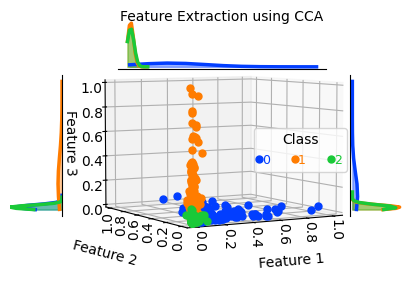

In [161]:
# ----------------------------------- Step 1: Combine all of datasets ----------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data2.shape[-1], 1), np.full(data3.shape[-1], 2)))    # predicted results
# -------------------------------- Step 2: Filtering for all of datasets -------------------------------------
order = 4                # Define filter order
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
subbands = [[12, 16, 20],
            [14, 18, 22]]
f_low = np.min(subbands) - 1  # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = np.max(subbands) + 1 # Define upper cutoff frequency for the bandpass filter (Hz)
notch_filter = "on"       # on or off
filter_active = "on"      # on or off
type_filter = "bandpass"  # low, high, bandpass, or bandstop
# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, 
                                    filter_active, notch_filter, type_filter)
# ------------------------------------- Step 3: CAR for all of datasets --------------------------------------
data_car = Common_average_reference.car(filtered_data) 
# ---------------------------------- Step 4: Feature Extraction using CCA ------------------------------------
num_harmonic = 4          # Number of harmonic for each frequency stimulation
f_stim = [13, 21, 17]     # Frequencies stimulation
num_channel = [0, 1]      # Number of Channel     
title = f"Feature Extraction using CCA"

# Perform cca_feature_extraction analysis for multiple channels
features_extraction = CCA_Feature_Extraction.cca_feature_extraction(data_car, fs, f_stim, num_channel, num_harmonic)

# print(data_total.shape)
print(features_extraction.shape)
# print(features_extraction)

Plot_features.plot_features(features_extraction, labels, title, location_legend=5)

In [162]:
feature_selection_path='/home/ubie/Desktop/Telekinesis/classify/Code/Python/feature_selector.joblib'

def feature_selection(data, labels):
    selector = SelectKBest(score_func=f_classif, k=6)
    selected_features = selector.fit_transform(data, labels)
    joblib.dump(selector, feature_selection_path)
    return selected_features

(480,)
(480, 6)


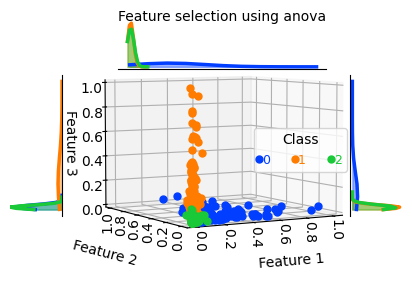

In [165]:
num_features = 24                  # pick any random high number it's result won't go beyond its limits :)
n_neighbors_MI = 5                 # Number of neighbors to consider for mutual information calculation.
L1_Parameter = 0.2                 # Parameter value for L1 regularization.
threshold_var = 0.001              # The threshold used for variance thresholding.
type_feature_selection = "anova"   # var, anova, mi, ufs, rfe, rf, l1fs, tfs, fs, ffs, bfs
title = f"Feature selection using {type_feature_selection}"

print(labels.shape)

#features = Feature_selections.feature_selecions(features_extraction, labels, num_features,threshold_var, n_neighbors_MI, L1_Parameter, type_feature_selection)


features = feature_selection(features_extraction, labels)
print(features.shape)
Plot_features.plot_features(features, labels, title, location_legend=5, fig_size=(4, 3))

In [136]:
scaler_filename = r"/home/ubie/Desktop/Telekinesis/classify/Code/Python/normalize.joblib"

# ================================================== Data normalization ==================================================
def data_normalization(x_train, x_test, method="MinMaxScaler"):    
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        
    if method == "MinMaxScaler":
        norm = preprocessing.MinMaxScaler()
    elif method == "StandardScaler":
        norm = preprocessing.StandardScaler()
        
    x_train = norm.fit_transform(x_train)
    x_test = norm.transform(x_test)

    # Save the fitted scaler
    joblib.dump(norm, scaler_filename)
    
    return x_train, x_test

# ================================================== classification ====================================================== 
def classification(model, data, labels, k_fold=5, normalize_active="off", method="MinMaxScaler",type_class="LR"):
   # -------------------------------------------------------- K_fold --------------------------------------------------------------
    cv = model_selection.StratifiedKFold(n_splits=k_fold)     
   
    for j, (train, test) in enumerate(cv.split(data, labels)):  
      # --------------------------------------------------- Split data ------------------------------------------------------------
      data_train = data[train] 
      data_test = data[test]
      label_train = labels[train]
      label_test = labels[test]
      # ------------------------------------------------------ Print Shapes -------------------------------------------------------
      print(f"Data train at iteration {j} : {data_train.shape}")
      print(f"Label train at iteration {j} : {label_train.shape}",end='\n\n')

      print(f"Data test at iteration {j} : {data_test.shape}")
      print(f"Label test at iteration {j} : {label_test.shape}",end='\n')

      # -------------------------------------------------- Data normalization -----------------------------------------------------
      if normalize_active == "on": 
          data_train, data_test = data_normalization(data_train, data_test, method=method)   # method 1: MinMaxScaler, method 2: StandardScaler
      # ---------------------------------------------------- Training Network -----------------------------------------------------
      model.fit(data_train, label_train)                                           # Fit i.e., Training
      # ---------------------------------------------- Training Section -----------------------------------------------------------
      label_predict_train = model.predict(data_train)
      print("label_predict_train :", label_predict_train,end='\n')

      # ----------------------------------------------- Test Section --------------------------------------------------------------
      label_predict_test = model.predict(data_test)
      print("label_predict_test :", label_predict_test,end='\n\n')


    return model

# ============================================== Classification methods ================================================== 
def classification_methods(data, labels, k_fold, kernel_SVM, C_SVM, normalize_active, method):
                           
   model = svm.SVC(kernel=kernel_SVM, random_state=0, C=C_SVM, gamma="auto", probability=True) # sklearn

   trained_model = classification(model, data, labels, k_fold, normalize_active, method,type_class="SVM")   
   return trained_model


In [137]:
# ------------------------------------------------------ SVM --------------------------------------------
C_SVM = 100
criterion = "gini"                                  # gini, entropy, log_loss for DT and RF
kernel_SVM ="linear"                                # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

k_fold = 4

method = "MinMaxScaler"                          # MinMaxScaler" , StandardScaler for data normalization 
normalize_active = "on"                          # normalize_active for data normalization

print("features = ",features.shape,end='\n\n')

print("labels = ",labels.shape)

trained_model = classification_methods(features, labels, k_fold, kernel_SVM, C_SVM, normalize_active, method)


features =  (480, 6)

labels =  (480,)
Data train at iteration 0 : (360, 6)
Label train at iteration 0 : (360,)

Data test at iteration 0 : (120, 6)
Label test at iteration 0 : (120,)
label_predict_train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
label_predict_test : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

### Model Save

In [138]:
import joblib  # Import joblib for saving and loading models

model_save_path = r"/home/ubie/Desktop/Telekinesis/classify/Code/Python/trained_model.pkl"

joblib.dump(trained_model, model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /home/ubie/Desktop/Telekinesis/classify/Code/Python/trained_model.pkl


### Model Testing

In [149]:
def count_values(arr):
    """
    Function to count occurrences of 0s, 1s, and 2s in a given array.
    
    Parameters:
    arr (list): The input array containing numbers.
    
    Returns:
    tuple: A tuple containing the count of 0s, 1s, and 2s in the array.
    """
    count_zeros = np.count_nonzero(arr == 0)
    count_ones = np.count_nonzero(arr == 1)
    count_twos = np.count_nonzero(arr == 2)
        
    return count_zeros, count_ones, count_twos

def normalize_inference(x_real_time, scaler_filename="normalize.joblib"):
    # Load the saved scaler
    norm = joblib.load(scaler_filename)
    
    if x_real_time.ndim == 1:
        x_real_time = x_real_time.reshape(-1, 1)
    
    x_real_time_normalized = norm.transform(x_real_time)
    
    return x_real_time_normalized

print(features.shape)

saved_model = joblib.load("trained_model.pkl")

# input_13 = features[:160,:]
# input_21 = features[160:320,:]
# input_17 = features[320:480,:]

input_13 = normalize_inference(features[:160,:])
input_21 = normalize_inference(features[160:320,:])
input_17 = normalize_inference(features[320:480,:])


# input_13 = features_extraction[:160,:]
# input_21 = features_extraction[160:320,:]
# input_17 = features_extraction[320:480,:]

print("input size", input_13.shape)


feature_output = saved_model.predict(input_13)

z1,o1,t1 = count_values(feature_output)

print(f"predicted result = {feature_output}")

print(f"Result : Zeros: {z1}, Ones: {o1}, Twos: {t1}")

# mapping with commands

mapping = { 0 : "0", 1 : "1" , 2 : "2"}
print(mapping[ 0 if z1 > o1 and z1 > t1 else 1 if o1 > t1 else 2])


(480, 6)
input size (160, 6)
predicted result = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0]
Result : Zeros: 152, Ones: 8, Twos: 0
0
